# Histogram Specification

In [1]:
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np

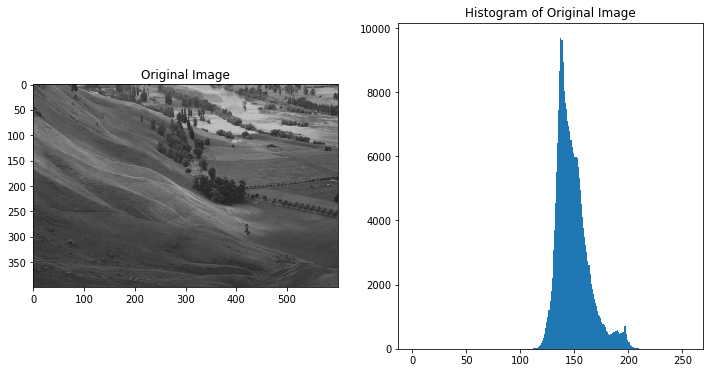

In [2]:
PATH = 'images/histogram.jpg'
img = cv2.imread(PATH, 0)


fix, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[1].hist(img.ravel(), 256, [0, 256])
ax[1].set_title('Histogram of Original Image')
plt.show()

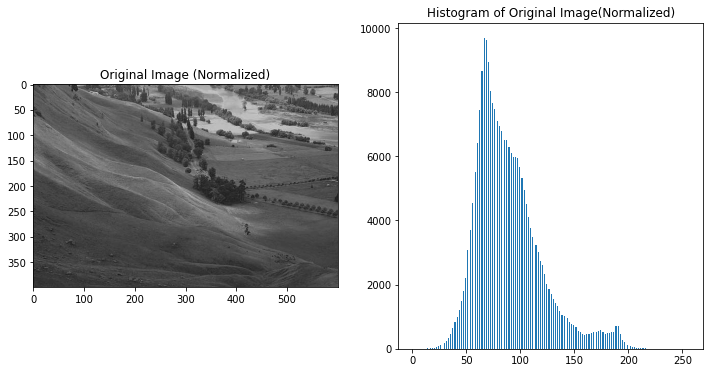

In [3]:
a_min = img.min()
a_max = img.max()
row, col = img.shape[:2]

for i in range (row):
    for j in range(col):
        img[i][j] = (((img[i][j] - a_min) / (a_max - a_min)) *255)
img = img.astype(np.uint8)

fix, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image (Normalized)')
ax[1].hist(img.ravel(), 256, [0, 256])
ax[1].set_title('Histogram of Original Image(Normalized)')
plt.show()

In [4]:
def frequency_count(image):
    frequency = np.zeros((256), dtype = int)
    row, col = image.shape[:2]
    for i in range(row):
        for j in range(col):
            x = image[i][j]
            frequency[x] += 1
    return frequency


In [5]:
def get_cdf(pdf):
    cdf = np.zeros((256), dtype = float)
    rounded = np.zeros((256), dtype = int)
    cdf[0] = pdf[0]
    rounded[0] = round(cdf[0] * (256 - 1))
    
    for i in range(1,pdf.shape[0]):
        cdf[i] = cdf[i-1] + pdf[i]
        rounded[i] = round(cdf[i] * (256 - 1))
    return cdf, rounded

In [6]:
def histogram_specification(img, miu = 208, sigma = 50):
    row, col = img.shape[:2]
    L = 256
    # gaussian / normal distribution
    guass_func = np.random.normal(miu, sigma, size=(row, col))
    # round up and type cust to int from float
    guass_func = np.round(guass_func).astype(int);
    
    # make the range between 0-255 by thresholding
    guass_func[guass_func>255]=255
    guass_func[guass_func<0]= 0
    
    # frequency of each intensity 
    freq_input = frequency_count(img)
    freq_guass = frequency_count(guass_func)
    
    # image size
    inp_img_size = row * col
    guass_size = guass_func.shape[0] * guass_func.shape[1]
    
    # PDF or normalized histogram
    pdf_input = freq_input/inp_img_size
    pdf_guass = freq_guass/guass_size
    
    
    # CDF and transformation function calculation 
    cdf_input,trans_input = get_cdf(pdf_input)  
    cdf_guass,trans_guass = get_cdf(pdf_guass) 
    
    # histogram matching
    final_map_input = np.zeros((L), dtype = int)
    final_map_input2 = np.zeros((L), dtype = int)
    
    for i in range(L):
        for j in range(L):
            if trans_input[i] == trans_guass[j]:
                final_map_input[i] = j
                final_map_input2[i] = j
                break
            elif trans_input[i] < trans_guass[j]:
                prev_dis = trans_input[i] - trans_guass[j-1]
                current_dis = trans_guass[j] - trans_input[i]
                if current_dis<prev_dis:
                    final_map_input[i] = j
                    final_map_input2[i] = j-1
                else:
                    final_map_input[i] = j-1
                    final_map_input2[i] = j
                break
    
    img_new = copy.deepcopy(img)
    img_new2 = copy.deepcopy(img)
    for i in range(img_new2.shape[0]):
        for j in range(img_new2.shape[1]):
            img_new[i][j] = final_map_input[img[i][j]]
            img_new2[i][j] = final_map_input2[img[i][j]]
    
    # frequency of each intensity 
    freq_matched_img = frequency_count(img_new)
    # PDF or normalized histogram
    pdf_matched_img = freq_matched_img/inp_img_size
    # CDF and transformation function calculation 
    cdf_matched_img,trans_matched_img = get_cdf(pdf_matched_img)
    
    return guass_func, cdf_input, cdf_guass, img_new, img_new2, cdf_matched_img


In [7]:
# to plot histogram
def plot_histogram(histogram, title):
    plt.hist(histogram.ravel(), 256 ,[0, 256-1])
    plt.title(title)
    plt.show()

# to plot array
def plot_data(data, title): 
    plt.plot(data)
    plt.title(title)
    plt.show()

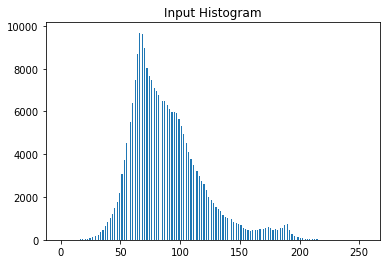

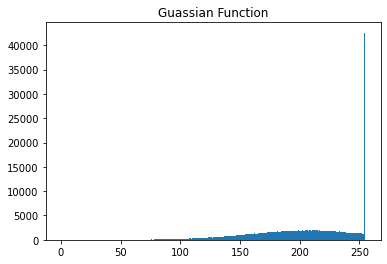

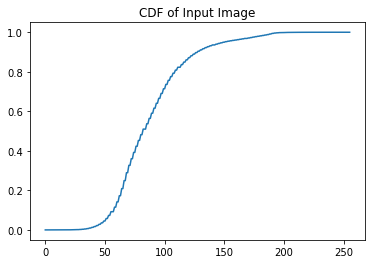

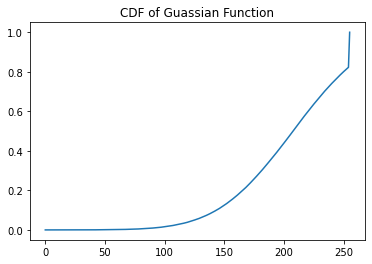

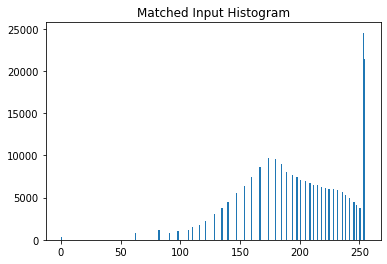

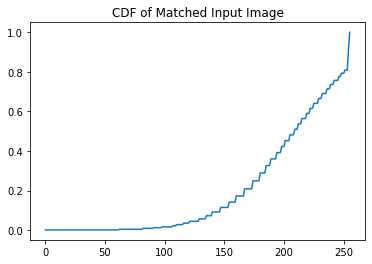

In [8]:
# histogram specification output
guass_f, img_cdf, guass_cdf, matched_img, matched2, matched_cdf = histogram_specification(img)

# plot the input historam
plot_histogram(img, "Input Histogram")
# plot the gaussian histogram
plot_histogram(guass_f, "Guassian Function")
# plot the cdf of input image
plot_data(img_cdf, "CDF of Input Image")
# plot the cdf of guassian
plot_data(guass_cdf, "CDF of Guassian Function")
# plot the mapped input historam
plot_histogram(matched_img, "Matched Input Histogram")
# plot the cdf of mapped input image
plot_data(matched_cdf, "CDF of Matched Input Image")

Text(0.5, 1.0, 'Matched Image2')

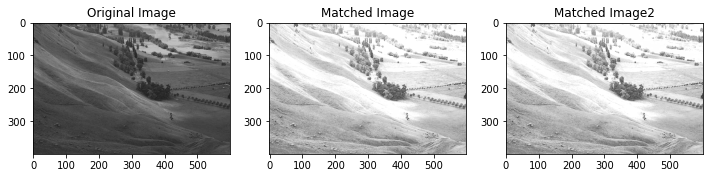

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(matched_img, cmap='gray')
ax[1].set_title('Matched Image')
ax[2].imshow(matched2, cmap='gray')
ax[2].set_title('Matched Image2')